# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [5]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: это вероятности попадания каждого предсказания в положительный класс, так как мы выбираем равновероятно, то и вероятности равны 0.5

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [6]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


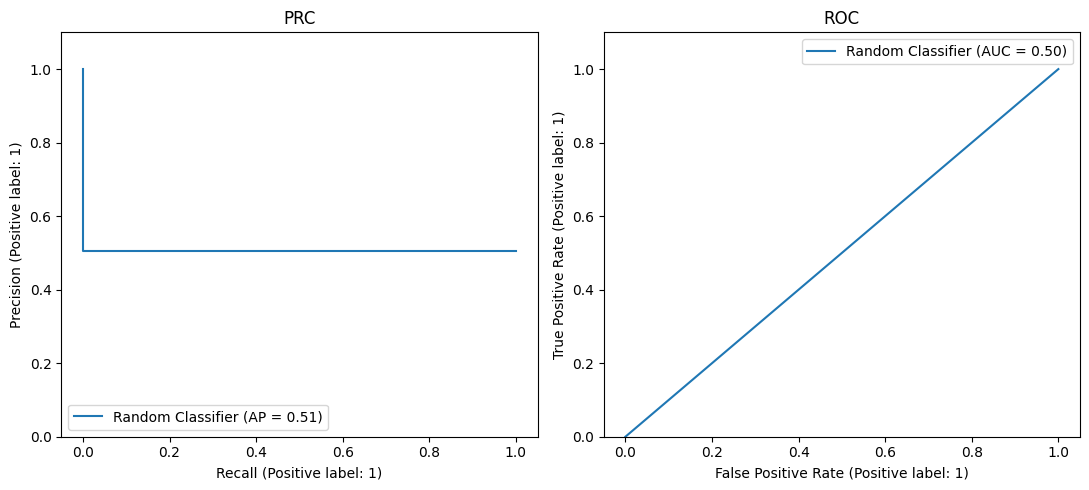

In [7]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [8]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [10]:
cs = np.logspace(-5, 5, 20)
aucs = []

for c in cs:
  model = LinearSVC(dual=False, C=c)
  model.fit(X_train, y_train)
  y_val_pred = model.predict(X_val)
  precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
  aucs.append(auc(recall, precision))

best_c_svc = cs[np.argmax(aucs)]

In [11]:
best_c_svc

0.000379269019073225

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

LinearSVC Classifier metrics
AUC-PR: 0.83184
AUC-ROC: 0.84545


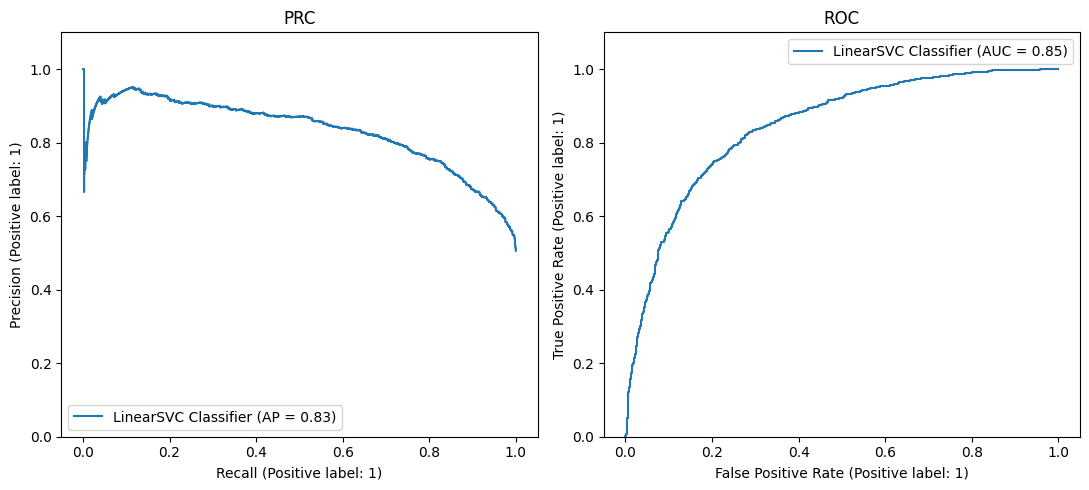

In [12]:
svc_model = LinearSVC(dual=False, C=best_c_svc)
svc_model.fit(X_train, y_train)

depict_pr_roc(y_test, svc_model.decision_function(X_test), 'LinearSVC Classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [13]:
print("Random AUC-PR: 0.75283")
print("Random AUC-ROC: 0.50000")
print("LinearSVC AUC-PR: 0.83184")
print("LinearSVC AUC-ROC: 0.84545")

Random AUC-PR: 0.75283
Random AUC-ROC: 0.50000
LinearSVC AUC-PR: 0.83184
LinearSVC AUC-ROC: 0.84545


Получилось заметно лучше

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [14]:
aucs = []

for c in cs:
  model = LogisticRegression(penalty='l2', dual=False, C=c)
  model.fit(X_train, y_train)
  y_val_pred = model.predict(X_val)
  precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
  aucs.append(auc(recall, precision))

best_c_log = cs[np.argmax(aucs)]

LR Classifier metrics
AUC-PR: 0.83224
AUC-ROC: 0.84718


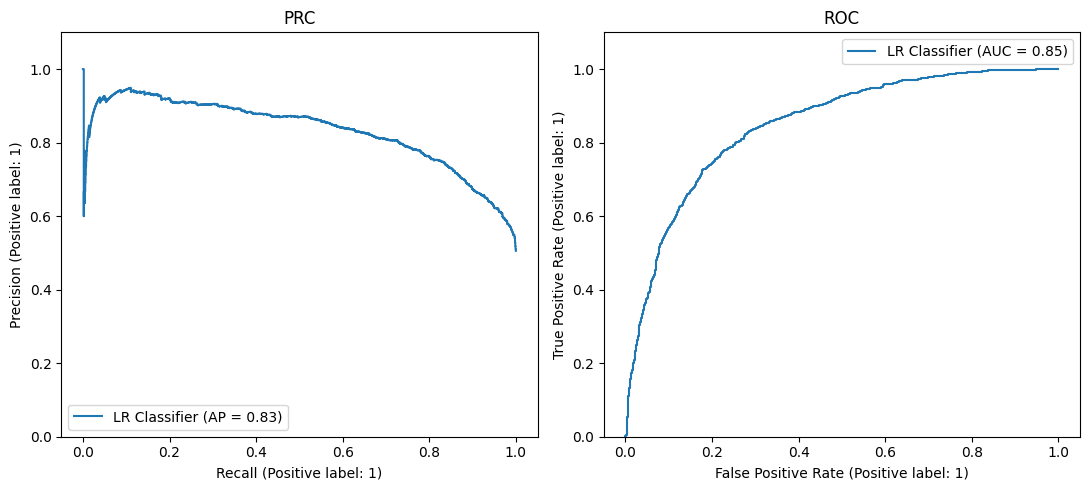

In [15]:
log_model = LogisticRegression(dual=False, C=best_c_log)
log_model.fit(X_train, y_train)

depict_pr_roc(y_test, log_model.predict_proba(X_test)[:,1], 'LR Classifier')

Получилось заметно лучше, примерно также, как с SVC

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
SVC Classifier metrics
AUC-PR: 0.83184
AUC-ROC: 0.84545
LR Classifier metrics
AUC-PR: 0.83224
AUC-ROC: 0.84718


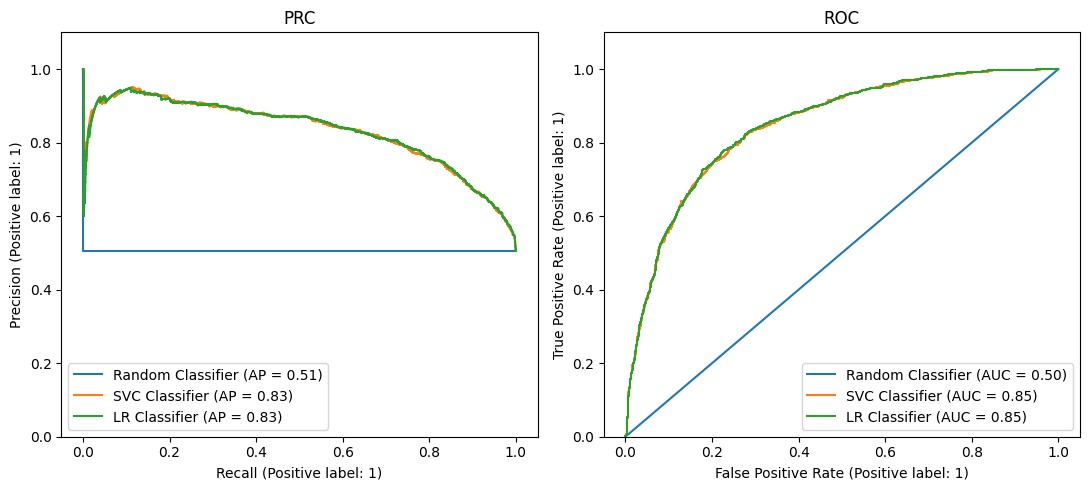

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, svc_model.decision_function(X_test), 'SVC Classifier', ax=ax)
depict_pr_roc(y_test, log_model.predict_proba(X_test)[:,1], 'LR Classifier', ax=ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** метрики для этих методов очень похожи, отличаются в третьем порядке после запятой, на грфиках видно небольшое различие, но общее поведение такое же

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [17]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = SVC(kernel='linear', C=best_c_svc)
model.fit(X_train, y_train)

SVC(C=0.000379269019073225, kernel='linear')

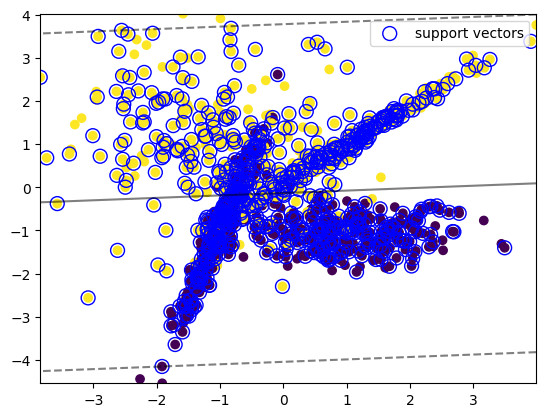

In [18]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(30, 30)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:,0], X[:,1], c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** выделенные синим цветом

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [19]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(penalty='l2', dual=False, C=best_c_log)
model.fit(X_train, y_train)

LogisticRegression(C=0.04832930238571752)

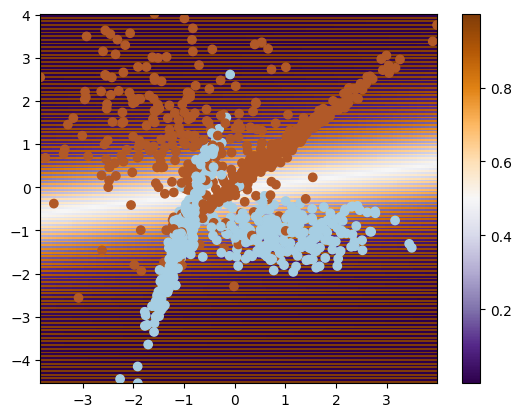

In [20]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:,0], X[:,1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** она выделена белым цветом, из лекций знаем, что такие объекты лежат на разделяющей гиперплоскости, их вероятность равна 0.5, так как модель не знает, куда отнести этот объект и выдаёт равные вероятности принадлежности к каждому из классов

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [21]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

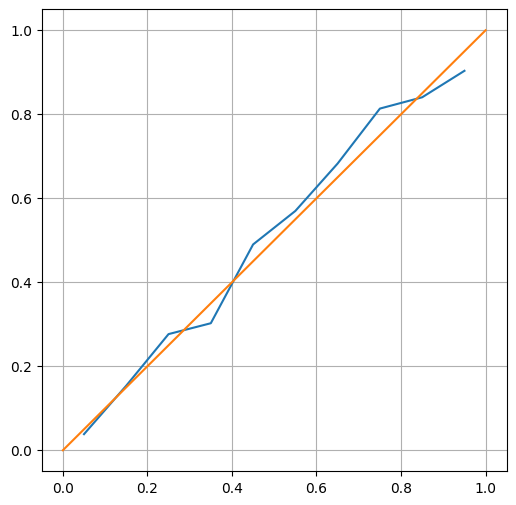

In [22]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
xs =[0, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
log_model = LogisticRegression(penalty='l2', C=best_c_log)
log_model.fit(X_train, y_train)
plot_calibration_curve(y_test, log_model.predict_proba(X_test)[:,1])
plt.plot(xs, xs)

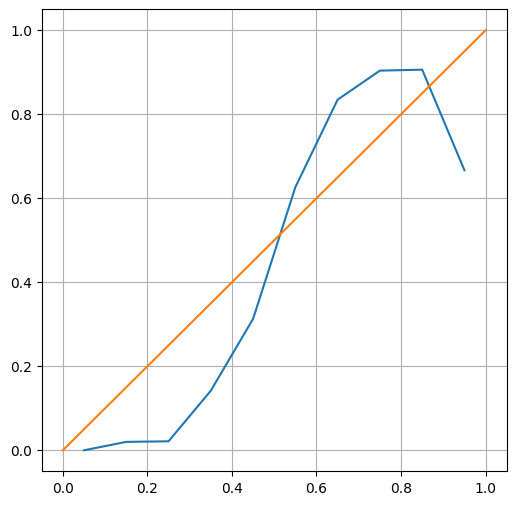

In [23]:
def normalize(arr):
  arr -= np.min(arr)
  arr /= np.max(arr)
  return arr

svc_model = LinearSVC(penalty='l2', C=best_c_log)
svc_model.fit(X_train, y_train)
plot_calibration_curve(y_test, normalize(svc_model.decision_function(X_test)))
plt.plot(xs, xs)

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** так как логистическая регрессия предсказывает вероятности, то и вероятности соответствующие получились откалиброванными, в случае метода опорных векторов ситуация хуже. Но это и ожидаемо, так как наша модель и не стремилась их оценивать.

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

(array([  8.,  50., 187., 437., 684., 728., 557., 281.,  64.,   4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

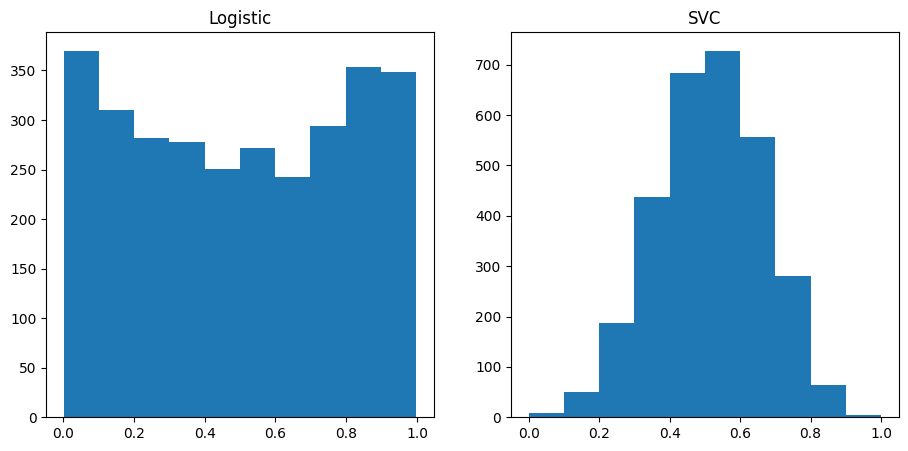

In [24]:
f, ax = plt.subplots(1, 2, figsize=(11, 5))
ax[0].set_title('Logistic')
ax[1].set_title('SVC')
ax[0].hist(log_model.predict_proba(X_test)[:,1])
ax[1].hist(normalize(svc_model.decision_function(X_test)))

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** в случае логистической регрессии вероятности как будто из смеси двух нормальных распределений, это хорошо, так как мы часто оцениваем вероятности, в случае SVM распределение похоже на нормальное, со средним 0.5, что не очень хорошо, так как в среднем вероятности близки к равновероятному выбору

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

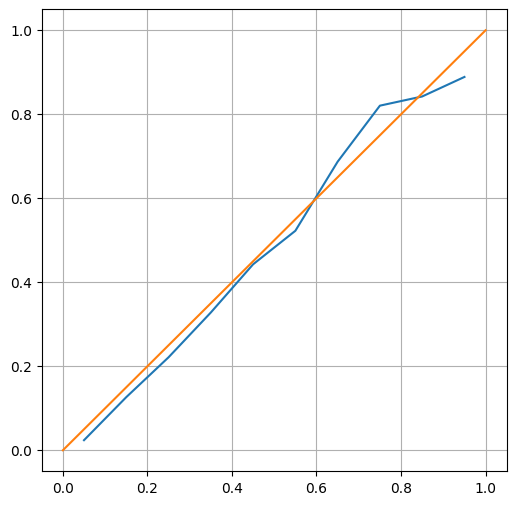

In [25]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
clf_model = CalibratedClassifierCV(svc_model, cv='prefit')
clf_model.fit(X_val, y_val)
plot_calibration_curve(y_test, clf_model.predict_proba(X_test)[:,1])
plt.plot(xs, xs)

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** да очень сильно улучшилась, теперь она почти совпадает с оптимальной

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [26]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [31]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных


X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
numeric=['Income', 'Children', 'Cars', 'Age']
X_numerical = X[numeric]
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation',
                    'Home Owner', 'Commute Distance', 'Region']
X_categorical = X[categorical]
X_categorical = X_categorical.fillna('undefined')

В начале поработаем только с категориальными признаками

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [33]:
start = time.time()
enc = OrdinalEncoder()
ord_X_train = enc.fit_transform(X_train)
ord_X_test = enc.transform(X_test)

ord_model = LogisticRegression(penalty='l2', dual=False, C=best_c_log)
ord_model.fit(ord_X_train, y_train)
ord_y_test_pred = ord_model.predict(ord_X_test)
precision, recall, _ = precision_recall_curve(y_test, ord_y_test_pred)
print("AUC-PR", auc(recall, precision))
print("Time=", time.time()-start)

AUC-PR 0.6542411003236246
Time= 0.017345905303955078


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [34]:
start = time.time()
oh_enc = OneHotEncoder()
oh_X_train = oh_enc.fit_transform(X_train)
oh_X_test = oh_enc.transform(X_test)

oh_model = LogisticRegression(penalty='l2', dual=False, C=best_c_log)
oh_model.fit(oh_X_train, y_train)
oh_y_test_pred = oh_model.predict(oh_X_test)
precision, recall, _ = precision_recall_curve(y_test, oh_y_test_pred)
print("AUC-PR", auc(recall, precision))
print("Time=", time.time()-start)

AUC-PR 0.6817592592592593
Time= 0.028902053833007812


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [35]:
class MeanTargetEncoder:
  def __init__(self, categorical):
    self.categories = {}
    self.categorical = categorical

  def fit(self, X, y):
    X['target'] = y
    for col in self.categorical:
      self.categories[col] = X.groupby(col).agg({'target': 'mean'}).to_dict()
    X.drop(columns=['target'], inplace=True)

  def transform(self, X):
    X_res = X.copy(deep=True)
    for col in self.categorical:
      X_res[col] = X_res[col].map(self.categories[col]['target'])
    return X_res


start = time.time()
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation',
                    'Home Owner', 'Commute Distance', 'Region']
mte = MeanTargetEncoder(categorical)
mte.fit(X_train, y_train)
mte_X_train = mte.transform(X_train)
mte_X_test = mte.transform(X_test)

mte_model = LogisticRegression(penalty='l2', dual=False, C=best_c_log)
mte_model.fit(mte_X_train, y_train)
mte_y_test_pred = mte_model.predict(mte_X_test)
precision, recall, _ = precision_recall_curve(y_test, mte_y_test_pred)
print("AUC-PR", auc(recall, precision))
print("Time=", time.time()-start)

AUC-PR 0.74
Time= 0.042449235916137695


Потребовалось чуть больше времени, чем при OHE

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [36]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, categorical):
    self.categories = {}
    self.categorical = categorical

  def fit(self, X, y):
    X['target'] = y
    for col in self.categorical:
      self.categories[col] = X.groupby(col).agg({'target': 'mean'}).to_dict()
    X.drop(columns=['target'], inplace=True)

  def transform(self, X):
    X_res = X.copy(deep=True)
    for col in self.categorical:
      X_res[col] = X_res[col].map(self.categories[col]['target'])
    return X_res

start = time.time()
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation',
                    'Home Owner', 'Commute Distance', 'Region']
mte = MeanTargetEncoder(categorical)
mte.fit(X_train, y_train)
mte_X_train = mte.transform(X_train)
mte_X_test = mte.transform(X_test)

mte_model = LogisticRegression(penalty='l2', dual=False, C=best_c_log)
mte_model.fit(mte_X_train, y_train)
mte_y_test_pred = mte_model.predict(mte_X_test)
precision, recall, _ = precision_recall_curve(y_test, mte_y_test_pred)
print("AUC-PR", auc(recall, precision))
print("Time=", time.time()-start)

AUC-PR 0.74
Time= 0.06265568733215332


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [37]:
class MeanTargetEncoderWithNoise(BaseEstimator, TransformerMixin):
  def __init__(self, categorical):
    self.categories = {}
    self.categorical = categorical

  def fit(self, X, y):
    X['target'] = y
    for col in self.categorical:
      res = X.groupby(col).agg({'target': 'mean'})
      res['target'] += np.random.normal(0, 2.5, res.shape[0])
      self.categories[col] = res.to_dict()
    X.drop(columns=['target'], inplace=True)

  def transform(self, X):
    X_res = X.copy(deep=True)
    for col in self.categorical:
      X_res[col] = X_res[col].map(self.categories[col]['target'])
    return X_res

start = time.time()
mte_noise = MeanTargetEncoderWithNoise(categorical)
mte_noise.fit(X_train, y_train)
mte_noise_X_train = mte_noise.transform(X_train)
mte_noise_X_test = mte_noise.transform(X_test)

mte_noise_model = LogisticRegression(penalty='l2', dual=False, C=best_c_log)
mte_noise_model.fit(mte_noise_X_train, y_train)
mte_noise_y_test_pred = mte_noise_model.predict(mte_noise_X_test)
precision, recall, _ = precision_recall_curve(y_test, mte_noise_y_test_pred)
print("AUC-PR =", auc(recall, precision))
print("Time =", time.time()-start)

AUC-PR = 0.604702380952381
Time = 0.23805022239685059


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** качество ожидаемо ухудшилось, так как мы добавили случайности

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [38]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [39]:
class SmoothEncoder:
  def __init__(self, categorical, c=10):
    self.categories = {}
    self.categorical = categorical
    self.c = c

  def fit(self, X, y):
    X['target'] = y.copy()
    for col in self.categorical:
      res = X.groupby(col).agg({'target': 'sum'})
      res['target'] += self.c * X['target'].mean()
      res['target'] /= X.groupby(col).agg({'target': 'count'})['target'] + self.c
      res['target'] += np.random.normal(0, 2.5, res.shape[0])
      self.categories[col] = res.to_dict()
    X.drop(columns=['target'], inplace=True)

  def transform(self, X):
    X_res = X.copy(deep=True)
    for col in self.categorical:
      X_res[col] = X_res[col].map(self.categories[col]['target'])
    return X_res


categorical = ['Marital Status', 'Gender', 'Education', 'Occupation',
                    'Home Owner', 'Commute Distance', 'Region']
cs = np.linspace(0, 20, 20)
aucs=[]
times=[]
for c in cs:
  start = time.time()
  se = SmoothEncoder(categorical, c)
  se.fit(X_train, y_train)
  se_X_train = se.transform(X_train)
  se_X_test = se.transform(X_test)

  se_model = LogisticRegression(dual=False, C=best_c_log)
  se_model.fit(se_X_train, y_train)
  se_y_test_pred = se_model.predict(se_X_test)
  precision, recall, _ = precision_recall_curve(y_test, se_y_test_pred)
  aucs.append(auc(recall, precision))
  times.append(time.time()-start)
print("Best c =", cs[np.argmax(aucs)])
print("AUC-PR =", max(aucs))
print("Time =", times[np.argmax(aucs)])

Best c = 5.263157894736842
AUC-PR = 0.6857522935779816
Time = 0.09014749526977539


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [40]:
X[numeric] = X[numeric].fillna(X[numeric].mean())
X[categorical] = X[categorical].fillna('undefined')
X=X.drop(columns=['ID'])

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [41]:
X[numeric].nunique()

Income      17
Children     7
Cars         6
Age         54
dtype: int64

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

start = time.time()
features = categorical + numeric
mte = MeanTargetEncoder(categorical)
mte.fit(X_train, y_train)
mte_X_train = mte.transform(X_train)
mte_X_test = mte.transform(X_test)

mte_model = LogisticRegression(penalty='l2', dual=False, C=best_c_log, max_iter=10000)
mte_model.fit(mte_X_train, y_train)
mte_y_test_pred = mte_model.predict(mte_X_test)
precision, recall, _ = precision_recall_curve(y_test, mte_y_test_pred)
print("AUC-PR", auc(recall, precision))
print("Time=", time.time()-start)

AUC-PR 0.5923333333333334
Time= 0.07607173919677734


In [43]:
start = time.time()
oh_enc = OneHotEncoder()
oh_X_train = oh_enc.fit_transform(X_train)
oh_X_test = oh_enc.transform(X_test)

oh_model = LogisticRegression(penalty='l2', dual=False, C=best_c_log, max_iter=10000)
oh_model.fit(oh_X_train, y_train)
oh_y_test_pred = oh_model.predict(oh_X_test)
precision, recall, _ = precision_recall_curve(y_test, oh_y_test_pred)
print("AUC-PR", auc(recall, precision))
print("Time=", time.time()-start)

AUC-PR 0.7475412979351033
Time= 0.02720952033996582


Мы смогли добиться лучшего качество, чем было ранее

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ one-hot кодирование даёт лучшее качество, но требует большего количества памяти

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [44]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 14:03:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [  <=>               ]   3.79M  9.40MB/s    in 0.4s    

2023-11-22 14:03:37 (9.40 MB/s) - ‘adult.data’ saved [3974305]



In [45]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4986,19,Federal-gov,27433,12th,8,Never-married,Other-service,Own-child,White,Female,0,0,30,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [46]:
X_train, X_test,  y_train, y_test = train_test_split(df.drop(columns=['income']),  df['income'], test_size=0.25, random_state=777, stratify=df['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [47]:
categorical = ['workclass', 'education',
           'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num','capital-gain',
           'capital-loss', 'hours-per-week']
print("Before OHE features count:", len(X_train.columns))
oh_enc = OneHotEncoder()
oh_X_train = oh_enc.fit_transform(X_train[categorical])
oh_X_test = oh_enc.transform(X_test[categorical])
print("After OHE features count:", oh_X_train.shape[1])

Before OHE features count: 14
After OHE features count: 102


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [48]:
column_transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)])

reg = LogisticRegression(penalty='l2', dual=False, C=best_c_log, max_iter=10000)
oh_X_train = column_transformer.fit_transform(X_train)
reg.fit(oh_X_train, y_train)
oh_X_test = column_transformer.transform(X_test)
y_test_pred = reg.predict_proba(oh_X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
print("AUC-PR", auc(recall, precision))

AUC-PR 0.6891285637783787


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [49]:
start = time.time()
largest_40_coefs = np.argsort(np.abs(reg.coef_)[0])[::-1][:40]
oh_X_train = oh_X_train[:, largest_40_coefs]
oh_X_test = oh_X_test[:, largest_40_coefs]

model = LogisticRegression(penalty='l2', dual=False, C=best_c_log, max_iter=10000)
model.fit(oh_X_train, y_train)
y_test_pred = model.predict_proba(oh_X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

print("Time =", time.time() - start)
print("AUC-PR", auc(recall, precision))

Time = 0.3830695152282715
AUC-PR 0.687280809697582


Изменилось ли качество? Как?

Качество стало чуть хуже

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [50]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)])

start = time.time()
model = LogisticRegression(penalty='l2', dual=False, C=best_c_log)
oh_sc_X_train = column_transformer.fit_transform(X_train)
model.fit(oh_sc_X_train, y_train)
oh_sc_X_test = column_transformer.transform(X_test)

largest_40_coefs = np.argsort(np.abs(model.coef_)[0])[::-1][:40]
oh_sc_X_train = oh_sc_X_train[:, largest_40_coefs]
oh_sc_X_test = oh_sc_X_test[:, largest_40_coefs]

model = LogisticRegression(penalty='l2', dual=False, C=best_c_log, max_iter=10000)
model.fit(oh_sc_X_train, y_train)
y_test_pred = model.predict_proba(oh_sc_X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

print("Time =", time.time() - start)
print("AUC-PR", auc(recall, precision))

Time = 0.4956810474395752
AUC-PR 0.765674739270559


Мы добились сильного улучшения модели

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [51]:
scaler = StandardScaler(with_mean=False)

start = time.time()
model = LogisticRegression(penalty='l2', dual=False, C=best_c_log)
oh_sc_X_train = scaler.fit_transform(column_transformer.fit_transform(X_train))
model.fit(oh_sc_X_train, y_train)
oh_sc_X_test = scaler.fit_transform(column_transformer.fit_transform(X_test))

largest_40_coefs = np.argsort(np.abs(model.coef_)[0])[::-1][:40]
oh_sc_X_train = oh_sc_X_train[:, largest_40_coefs]
oh_sc_X_test = oh_sc_X_test[:, largest_40_coefs]

model = LogisticRegression(penalty='l2', dual=False, C=best_c_log, max_iter=10000)
model.fit(oh_sc_X_train, y_train)
y_test_pred = model.predict(oh_sc_X_test)
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

print("Time =", time.time() - start)
print("AUC-PR", auc(recall, precision))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Time = 0.6125421524047852
AUC-PR 0.7174026723104658


качество немного улучшилось, но не критично

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [52]:
start = time.time()
oh_sc_X_train = column_transformer.fit_transform(X_train)
n_minus = (y_train == 0).sum()
n_plus = (y_train == 1).sum()
t_stats = []

for_t_stat_X_train = pd.DataFrame.sparse.from_spmatrix(oh_sc_X_train)

for column in for_t_stat_X_train.columns:
  col = for_t_stat_X_train[column].to_numpy()
  m_minus = col[y_train == 0].mean()
  m_plus = col[y_train == 1].mean()
  s_minus = col[y_train == 0].std()
  s_plus = col[y_train == 1].std()
  t_stats.append(np.abs(m_plus - m_minus) / np.sqrt((n_plus*s_plus+n_minus*s_minus)/(n_plus + n_minus)))

oh_sc_X_test = column_transformer.fit_transform(X_test)

largest_40_coefs = np.argsort(np.abs(t_stats))[::-1][:40]
oh_sc_X_train = oh_sc_X_train[:, largest_40_coefs]
oh_sc_X_test = oh_sc_X_test[:, largest_40_coefs]

model = LogisticRegression(penalty='l2', dual=False, C=best_c_log, max_iter=10000)
model.fit(oh_sc_X_train, y_train)
y_test_pred = model.predict_proba(oh_sc_X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

print("Time =", time.time() - start)
print("AUC-PR", auc(recall, precision))

Time = 0.5102462768554688
AUC-PR 0.7607537870849647


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [53]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [54]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [55]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-22 14:03:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.76MB/s    in 0.2s    

2023-11-22 14:03:54 (1.76 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [56]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [57]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [58]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [59]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=500)

numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
           'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']

categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome']

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [60]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)])

salaries = []
revenue = []
for train_idx, test_idx in kf.split(X):
  X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
  X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

  oh_sc_X_train = column_transformer.fit_transform(X_train)
  oh_sc_X_test = column_transformer.transform(X_test)

  model = LogisticRegression(dual=False, C=best_c_log, max_iter=10000)
  model.fit(oh_sc_X_train, y_train)
  y_test_pred = model.predict(oh_sc_X_test)
  salaries.append(y_test_pred.sum())
  revenue.append((y_test_pred & y_test).sum())

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [61]:
print("Average revenue:", np.mean(revenue) * 10)
print("Average salary:", np.mean(salaries))
print("Average profit:", np.mean(revenue) * 10 - np.mean(salaries))
print("Standard deviation:", np.std(revenue) * 10)

Average revenue: 2084.0
Average salary: 310.6
Average profit: 1773.4
Standard deviation: 95.4148835350125


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [62]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)])

salaries = []
revenue = []
for train_idx, test_idx in kf.split(X):
  X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
  X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

  oh_sc_X_train = column_transformer.fit_transform(X_train)
  oh_sc_X_test = column_transformer.transform(X_test)

  model = LogisticRegression(dual=False, C=best_c_log, max_iter=10000)
  model.fit(oh_sc_X_train, y_train)
  y_test_pred = model.predict(oh_sc_X_test)
  salaries.append(y_test_pred.sum())
  revenue.append((np.random.rand((y_test_pred & y_test).sum()) * 20).sum())

In [63]:
print("Average revenue:", np.mean(revenue))
print("Average salary:", np.mean(salaries))
print("Average profit:", np.mean(revenue) - np.mean(salaries))
print("Standard deviation:", np.std(revenue))

Average revenue: 2118.7762535510797
Average salary: 310.6
Average profit: 1808.1762535510798
Standard deviation: 165.4484495030764


Разницы особо не видно

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [64]:
from sklearn.model_selection import cross_val_score

def scorer(model, X, y):
  y_pred = model.predict(X)
  return (np.random.rand((y_pred & y).sum()) * 20).sum() - y_pred.sum()

lambdas = np.logspace(-4, 2, 10)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)])

mean_profits = []
std_profits = []
for c in lambdas:

  pipeline = Pipeline(steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression(dual=False, C=c, max_iter=10000)),
    ])

  profits = cross_val_score(pipeline, X=X, y=y, cv=5, scoring=scorer)
  mean_profits.append(np.mean(profits))
  std_profits.append(np.std(profits))

  print(c,  mean_profits[-1])

0.0001 645.4933390666341
0.00046415888336127773 817.4740540698374
0.002154434690031882 1141.058008795725
0.01 823.9568338158297
0.046415888336127774 760.4839467467052
0.21544346900318823 555.7225233430033
1.0 -145.55750081463012
4.641588833612772 -252.82585157909415
21.54434690031882 -274.7833101899181
100.0 -326.46897771442144


Выигрыша получить не удалось

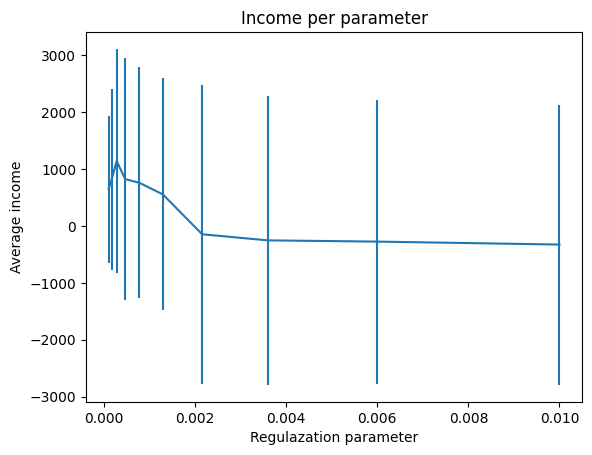

In [65]:
plt.errorbar(np.logspace(-4, 2, 10), mean_profits, std_profits)
plt.ylabel('Average income')
plt.xlabel('Regulazation parameter')
plt.title('Income per parameter')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [67]:
lambdas = np.logspace(-4, -2, 10)

for i in range(5):

  mean_profits = []
  std_profits = []
  for c in lambdas:
    pipeline = Pipeline(steps=[
          ('transform', column_transformer),
          ('classificator', LogisticRegression(dual=False, C=c, max_iter=10000)),
      ])

    profits = cross_val_score(pipeline, X=X, y=y, cv=5, scoring=scorer)
    mean_profits.append(np.mean(profits))
    std_profits.append(np.std(profits))

  print(i, lambdas[np.argmax(mean_profits)],  max(mean_profits))

0 0.002154434690031882 1169.3802730210878
1 0.002154434690031882 1153.5608920776187
2 0.002154434690031882 1186.745318048949
3 0.002154434690031882 1101.8885860945807
4 0.002154434690031882 1156.5273385463508


Лучшие коэффициенты получились одинаковые вне зависимости от итерации, никаких зависимостей не видно

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ так как потенциальная величина выигрыша намного больше, чем цена одного звонка, нам выгоднее оптимизировать recall, потому что нам не страшно лишний раз позвонить даже 8 людям, если 9 согласится на услугу, мы в среднем будем зарабатывать, так что нам важно увеличить полноту модели, но, конечно, нельзя забывать и про точность, так неправильные звонки тоже чего-то стоят.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [68]:
from sklearn.metrics import precision_score, recall_score
best_c = 0.002154434690031882

column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
        ('transform', column_transformer),
        ('classificator', LogisticRegression()),
])
mean_profits = []
std_profits = []
ts = []
mean_precisions = []
mean_recalls = []

for t in np.linspace(0, 1, 100):
  profits = []
  precisions = []
  recalls = []
  for train_indexes, test_indexes in kf.split(X):
      X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
      X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]
      oh_sc_X_train = column_transformer.fit_transform(X_train)
      oh_sc_X_test = column_transformer.transform(X_test)

      model = LogisticRegression(dual=False, C=best_c, max_iter=10000)
      model.fit(oh_sc_X_train, y_train)
      probas = model.predict_proba(oh_sc_X_test)[:, 1]
      y_pred = np.where(probas >= t, 1, 0)

      precisions.append(precision_score(y_test, y_pred))
      recalls.append(recall_score(y_test, y_pred))
      profits.append((np.random.rand((y_pred & y_test).sum()) * 20).sum() - y_pred.sum())

  mean_profits.append(np.mean(profits))
  std_profits.append(np.std(profits))
  ts.append(t)
  mean_precisions.append(np.mean(precisions))
  mean_recalls.append(np.mean(recalls))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

In [69]:
best_profit = max(mean_profits)
best_t = ts[np.argmax(mean_profits)]

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




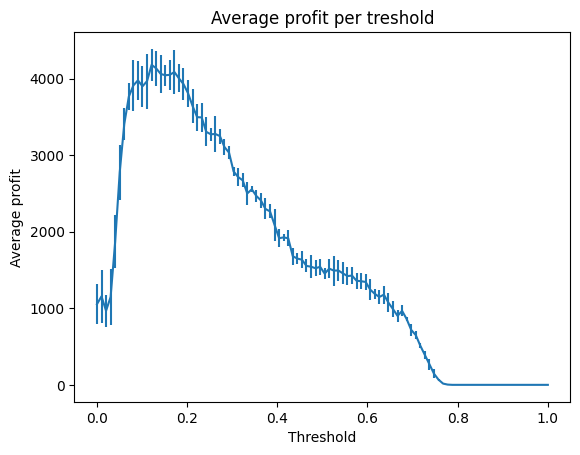

In [70]:
plt.errorbar(ts, mean_profits, std_profits)
plt.title('Average profit per treshold')
plt.ylabel('Average profit')
plt.xlabel('Threshold')
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ порог получается в конкретной области потому что именно там находится баланс при котором достигается оптимальная прибыль

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [71]:
precisions = []
recalls = []

for train_indexes, test_indexes in kf.split(X):
    X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
    X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]
    oh_sc_X_train = column_transformer.fit_transform(X_train)
    oh_sc_X_test = column_transformer.transform(X_test)

    model = LogisticRegression(dual=False, C=best_c, max_iter=10000)
    model.fit(oh_sc_X_train, y_train)
    probas = model.predict_proba(oh_sc_X_test)[:, 1]
    y_pred = np.where(probas >= best_t, 1, 0)

    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

print('Mean precision',  np.mean(precisions))
print('Std precision',  np.std(precisions))
print('Mean recall',  np.mean(recalls))
print('Std recall',  np.std(recalls))

Mean precision 0.3055966072107588
Std precision 0.013073681446793127
Mean recall 0.6595048715173363
Std recall 0.017602426468676474


Как и ожидалось наша модель оптимизирует recall, жертвуя значением precision

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [80]:
def normalize(arr):
  arr -= min(arr)
  arr /= max(arr)
  return arr

precisions_recalls=[]
for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
    X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]
    oh_sc_X_train = column_transformer.fit_transform(X_train)
    oh_sc_X_test = column_transformer.transform(X_test)

    model = LogisticRegression(dual=False, C=best_c, max_iter=10000)
    model.fit(oh_sc_X_train, y_train)
    probas = model.predict_proba(oh_sc_X_test)[:, 1]

    for t in ts:
      y_pred = np.where(probas >= t, 1, 0)
      recall = recall_score(y_test, y_pred)
      if recall >= 0.5:
        precisions_recalls.append([precision_score(y_test, y_pred), recall])
precisions_recalls = np.array(sorted(precisions_recalls, key=lambda x: x[1]))
precisions = normalize(precisions_recalls[:,0])
recalls = normalize(precisions_recalls[:,1])
print("PR-AUC:", auc(recalls, precisions))

PR-AUC: 0.4167703858937865


__Бонус (10 баллов):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ я кушал макарошки с мясом